# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [6]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

'pip3' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [33]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

from torchvision import transforms

In [4]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [8]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [9]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [10]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [11]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [12]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, lr_scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
        if lr_scheduler is not None:
            lr_scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    correct_samples = 0
    total_samples = 0
        
    for x, y in loader:
      
      x_gpu = x.to(device)
      y_gpu = y.to(device)
      
      prediction = model(x_gpu)
      _, indices = torch.max(prediction, 1)
      correct_samples += torch.sum(indices == y_gpu)
      total_samples += y.shape[0]

    return 0.0 if not total_samples else float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.400846, Train accuracy: 0.532266, Val accuracy: 0.770869
Average loss: 0.703912, Train accuracy: 0.784664, Val accuracy: 0.783974
Average loss: 0.610241, Train accuracy: 0.815872, Val accuracy: 0.821446
Average loss: 0.557736, Train accuracy: 0.832969, Val accuracy: 0.820081
Average loss: 0.527710, Train accuracy: 0.842712, Val accuracy: 0.831479


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [13]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

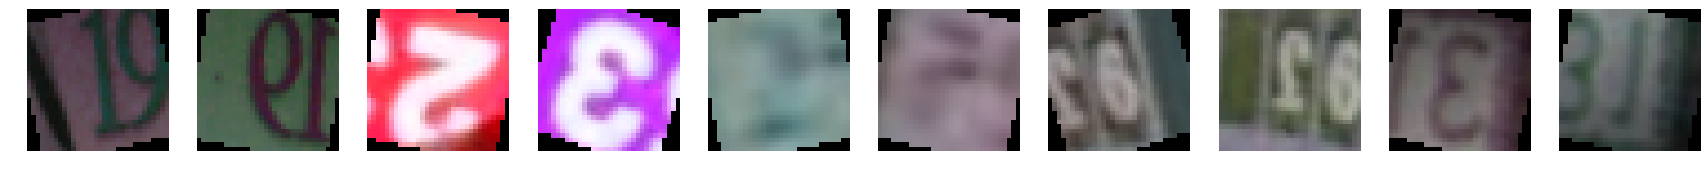

In [14]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Ответ: нет, горизонтальные и вертикальные перевороты дают данные, которые не соответствуют действительности и производят некорректные данные.

Выберите из них только корректные

In [17]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [18]:
# Я пересоздал тут модель, потому что по мне логичнее, что надо не доучивать старую модель, а учить новую
# Только теперь аугментированные данные

nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [19]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 1.845058, Train accuracy: 0.354725, Val accuracy: 0.651901
Average loss: 0.964844, Train accuracy: 0.689349, Val accuracy: 0.746843
Average loss: 0.815900, Train accuracy: 0.743081, Val accuracy: 0.771347
Average loss: 0.754101, Train accuracy: 0.763778, Val accuracy: 0.792369
Average loss: 0.710582, Train accuracy: 0.780005, Val accuracy: 0.778377


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [24]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(16, 120, 5),
            nn.ReLU(inplace=True),
            Flattener(),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [25]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.860846, Train accuracy: 0.345647, Val accuracy: 0.717425
Average loss: 0.745213, Train accuracy: 0.771184, Val accuracy: 0.830728
Average loss: 0.572993, Train accuracy: 0.828038, Val accuracy: 0.857211
Average loss: 0.497750, Train accuracy: 0.848019, Val accuracy: 0.853867
Average loss: 0.454812, Train accuracy: 0.861772, Val accuracy: 0.874889
Average loss: 0.420105, Train accuracy: 0.872283, Val accuracy: 0.879326
Average loss: 0.402558, Train accuracy: 0.877077, Val accuracy: 0.874548
Average loss: 0.377904, Train accuracy: 0.885404, Val accuracy: 0.885810
Average loss: 0.362296, Train accuracy: 0.890540, Val accuracy: 0.893318
Average loss: 0.351113, Train accuracy: 0.893902, Val accuracy: 0.889018


# Подбор гиперпараметров

In [27]:
import itertools
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-3, 1e-4]
anneal_coeff = 0.5
anneal_epochs = [1, 5]
reg = [1e-3, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!
for hyper_params in itertools.product(learning_rates, anneal_epochs, reg):
  
    (learning_rate, anneal_epoch, r) = hyper_params
    print(hyper_params)

    lenet_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(16, 120, 5),
            nn.ReLU(inplace=True),
            Flattener(),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10),
          )

    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.Adam(lenet_model.parameters(), lr=learning_rate, weight_decay=r)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epoch, gamma=anneal_coeff)
    loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, lr_scheduler=scheduler)

    run_record[Hyperparams(learning_rate, anneal_epoch, r)] = RunResult(lenet_model, train_history, val_history, val_history[-1])


(0.001, 1, 0.001)
Average loss: 1.300183, Train accuracy: 0.564669, Val accuracy: 0.813733
Average loss: 0.648080, Train accuracy: 0.804201, Val accuracy: 0.848884
Average loss: 0.523053, Train accuracy: 0.842286, Val accuracy: 0.867449
Average loss: 0.471382, Train accuracy: 0.858786, Val accuracy: 0.875435
Average loss: 0.446255, Train accuracy: 0.865850, Val accuracy: 0.879121
Average loss: 0.433320, Train accuracy: 0.870218, Val accuracy: 0.880896
Average loss: 0.428892, Train accuracy: 0.871412, Val accuracy: 0.880691
Average loss: 0.425017, Train accuracy: 0.872590, Val accuracy: 0.881169
Average loss: 0.421283, Train accuracy: 0.873648, Val accuracy: 0.880554
Average loss: 0.421221, Train accuracy: 0.873494, Val accuracy: 0.881646
(0.001, 1, 1e-05)
Average loss: 1.290577, Train accuracy: 0.573371, Val accuracy: 0.804245
Average loss: 0.654556, Train accuracy: 0.803450, Val accuracy: 0.848338
Average loss: 0.522757, Train accuracy: 0.843241, Val accuracy: 0.863764
Average loss: 0

Average loss: 2.206621, Train accuracy: 0.200031, Val accuracy: 0.349942
Average loss: 1.579142, Train accuracy: 0.487254, Val accuracy: 0.637431
Average loss: 1.183003, Train accuracy: 0.635327, Val accuracy: 0.718995
Average loss: 1.012306, Train accuracy: 0.693052, Val accuracy: 0.754351
Average loss: 0.917931, Train accuracy: 0.721889, Val accuracy: 0.777012
Average loss: 0.860859, Train accuracy: 0.742125, Val accuracy: 0.786431
Average loss: 0.812922, Train accuracy: 0.758779, Val accuracy: 0.796806
Average loss: 0.793730, Train accuracy: 0.765690, Val accuracy: 0.801106
Average loss: 0.771668, Train accuracy: 0.772139, Val accuracy: 0.808136
Average loss: 0.759486, Train accuracy: 0.776269, Val accuracy: 0.811480


In [28]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.90, best hyperparams: Hyperparams(learning_rate=0.001, anneal_epochs=5, reg=1e-07)


In [ ]:
Так же я запустил подбор гиперпараметров в google colab с оптимизатором optim.SGD(best_model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=r)

И лучший получившийся результат там был для параметров (learning_rate=0.1, anneal_epochs=1, reg=1e-3)
С результатом train=0.913900, val=0.912088

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [38]:
best_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(16, 120, 5),
            nn.ReLU(inplace=True),
            Flattener(),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10),
          )

best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(best_model.parameters(), lr=1e-1, momentum=0.9, nesterov=True, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 15, lr_scheduler=scheduler)


Average loss: 1.233521, Train accuracy: 0.602669, Val accuracy: 0.755785
Average loss: 0.881540, Train accuracy: 0.736802, Val accuracy: 0.771415
Average loss: 0.621586, Train accuracy: 0.812715, Val accuracy: 0.834755
Average loss: 0.479399, Train accuracy: 0.855629, Val accuracy: 0.874207
Average loss: 0.400055, Train accuracy: 0.878937, Val accuracy: 0.890861
Average loss: 0.359172, Train accuracy: 0.892008, Val accuracy: 0.896935
Average loss: 0.330661, Train accuracy: 0.900846, Val accuracy: 0.899597
Average loss: 0.316301, Train accuracy: 0.906068, Val accuracy: 0.901099
Average loss: 0.311229, Train accuracy: 0.906870, Val accuracy: 0.902737
Average loss: 0.305716, Train accuracy: 0.908917, Val accuracy: 0.902259
Average loss: 0.303698, Train accuracy: 0.909753, Val accuracy: 0.902532
Average loss: 0.301604, Train accuracy: 0.910504, Val accuracy: 0.903078


KeyboardInterrupt: 

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [40]:
# TODO Write the code to compute accuracy on test set
best_model.eval() # Evaluation mode

data_test_size = data_test.data.shape[0]
data_test_indices = list(range(data_test_size))


train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

test_sampler = SequentialSampler(data_test_indices)

test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, sampler=test_sampler)
    
correct_samples = 0
total_samples = 0
final_test_accuracy = 0.0

for x, y in test_loader:

    x_gpu = x.to(device)
    y_gpu = y.to(device)

    prediction = best_model(x_gpu)
    _, indices = torch.max(prediction, 1)
    correct_samples += torch.sum(indices == y_gpu)
    total_samples += y.shape[0]

if total_samples:
    final_test_accuracy = float(correct_samples) / total_samples

print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9005838967424709
